In [1]:
import scanpy as sc
from scipy.linalg import svd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
import seaborn as sb
from sys import getsizeof
from math import log
import time
from statistics import mean, stdev
from scipy.stats import norm
import pickle
from sklearn.mixture import GaussianMixture as GMM
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import rpy2.rinterface_lib.callbacks
import logging
from IPython.display import display
import os
import time
start = time.time()
from statistics import mean, stdev
from scipy.stats import norm

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import anndata2ri
import warnings

warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython


## ############################## 2
ro.r('.libPaths()')
ro.r('library(clValid)')
ro.r('library(scran)')
ro.r('library(RColorBrewer)')
ro.r('library(slingshot)')
ro.r('library(monocle)')
ro.r('library(gam)')
ro.r('library(clusterExperiment)')
ro.r('library(ggplot2)')
ro.r('library(plyr)')
ro.r('library(MAST)')
ro.r('library(kohonen)')

array(['kohonen', 'MAST', 'plyr', 'clusterExperiment', 'gam', 'foreach',
       'monocle', 'DDRTree', 'irlba', 'VGAM', 'splines', 'ggplot2',
       'Matrix', 'slingshot', 'princurve', 'RColorBrewer', 'scran',
       'SingleCellExperiment', 'SummarizedExperiment', 'DelayedArray',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'BiocGenerics', 'parallel', 'stats4',
       'BiocParallel', 'clValid', 'cluster', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U20')

# User inputs

In [2]:
k_min = 2 
k_max = 25
k_step = 1 
data_loc = '/Users/pk/Data/' 
hvg_bool_filename = "bool_Luecken_pp_Seurat_hvg_manual_3200_numEigens_13_obs_2000"               
num_obs_keep = 2000  
partition = 1  # To differentiate the different sub_clusters i.e. 1 to 7 for this k-means 7-cluster input
cl_alg = "kmeans" # which algorithm to sub-cluster
num_cl = 7 # which number of clusters to sub-cluster

#### Load dimensionally reduced data set

In [3]:
k_range = range(k_min, k_max + 1, k_step)
U_datafile = data_loc + "U_reduced_" + hvg_bool_filename + '.pickle'
with open(U_datafile, 'rb') as handle:
    reduced_hvg_mx = pickle.load(handle)
reduced_hvg_mx.shape

(2000, 13)

#### Load list of lists of cluster labels

In [4]:
df_datafile = data_loc + 'Cluster_labels_df_bool_Luecken_pp_Seurat_hvg_manual_3200_obs_2000'
with open(df_datafile + '.pickle', 'rb') as handle:
    df_labels = pickle.load(handle)

#### To differentiate the different sub_clusters

In [5]:
hvg_bool_filename = hvg_bool_filename + "_partition_" + str(partition)

#### Extract cluster labels for this sub-clustering input 
i.e. bool_Luecken_pp_Seurat_hvg_manual_3200_numEigens_13_obs_2000

In [6]:
df_labels[(df_labels['cl_method'] == cl_alg) & (df_labels['num_clusters'] == num_cl)]

,cl_method,num_clusters,0,1,2,3,4,5,6,7,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
4,kmeans,7,1,7,7,1,7,4,6,1,...,1,4,4,7,7,6,4,2,1,7


#### Compare cluster sizes

In [7]:
df_labels.iloc[4, :].value_counts()

1         854
7         618
4         243
6         150
2          85
5          30
3          21
kmeans      1
Name: 4, dtype: int64

#### convert to numpy array 

In [8]:
km7_cl_labels = np.array(df_labels.iloc[4, :])
km7_cl_labels = km7_cl_labels[2:]

In [9]:
partitions = []
for cluster in range(1, 8):
    partitions.append(np.where(km7_cl_labels == cluster)[0])          

In [10]:
input_mx = reduced_hvg_mx[partitions[partition-1], :]

In [11]:
nr, nc = input_mx.shape
xvec = ro.FloatVector(input_mx.transpose().reshape((input_mx.size)))
xr = ro.r.matrix(xvec, nrow=nr, ncol=nc)

#### Call cluster algorithms in R

In [12]:
%%R -i xr -i data_loc -i hvg_bool_filename -i k_min -i k_max -i k_step -o cl_obj_eucl


clmethods <- c("kmeans", "hierarchical", "model", "sota", "pam", "clara", "diana", "fanny")
vlmethods = c("internal")
cl_obj <- clValid(xr, 
                       nClust = seq(k_min, k_max,k_step), 
                       clMethods = clmethods, 
                       validation = vlmethods, 
                       maxitems = 20000,
                       metric = "euclidean", 
                       verbose = TRUE) 


cl_obj_eucl = cl_obj
clv_file_name =paste(data_loc, "cl_obj_eucl_", hvg_bool_filename, ".rds")
plot_file_name =paste(data_loc, "cl_obj_eucl_", hvg_bool_filename, ".jpg")
summary_file_name =paste(data_loc, "cl_obj_eucl_SUMMARY_", hvg_bool_filename, ".txt")
sink(summary_file_name)
print(summary(cl_obj))
sink() 
saveRDS(cl_obj, file=clv_file_name)


jpeg(plot_file_name)
plot(cl_obj)
dev.off()


[1] "Finished internal validation, kmeans 2 clusters"
[1] "Finished internal validation, kmeans 3 clusters"
[1] "Finished internal validation, kmeans 4 clusters"
[1] "Finished internal validation, kmeans 5 clusters"
[1] "Finished internal validation, kmeans 6 clusters"
[1] "Finished internal validation, kmeans 7 clusters"
[1] "Finished internal validation, kmeans 8 clusters"
[1] "Finished internal validation, kmeans 9 clusters"
[1] "Finished internal validation, kmeans 10 clusters"
[1] "Finished internal validation, kmeans 11 clusters"
[1] "Finished internal validation, kmeans 12 clusters"
[1] "Finished internal validation, kmeans 13 clusters"
[1] "Finished internal validation, kmeans 14 clusters"
[1] "Finished internal validation, kmeans 15 clusters"
[1] "Finished internal validation, kmeans 16 clusters"
[1] "Finished internal validation, kmeans 17 clusters"
[1] "Finished internal validation, kmeans 18 clusters"
[1] "Finished internal validation, kmeans 19 clusters"
[1] "Finished inte

### Display and save summary of cluster metrics

In [13]:
del xr, xvec # was only needed for the R function
# first index is clustering method, second index is number of clusters, 3rd index is parameter 
# use double square brackets
print("Using the Euclidean distance metric ")
ro.r('summary(cl_obj_eucl)')

Using the Euclidean distance metric 

Clustering Methods:
 kmeans hierarchical model sota pam clara diana fanny 

Cluster sizes:
 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

Validation Measures:
                                  2        3        4        5        6        7        8        9       10       11       12       13       14       15       16       17       18       19       20       21       22       23       24       25
                                                                                                                                                                                                                                                  
kmeans       Connectivity   12.3833 107.5071 273.6480 308.9845 421.3091 380.5345 406.2262 472.3750 516.7639 530.6063 521.2897 531.6333 528.2472 590.6869 582.2020 583.9603 616.5587 603.8111 669.3369 651.4885 664.5488 688.5290 665.7845 700.0036
             Dunn            0.1829   0.0744   0.0820 

<rpy2.rinterface.NULLType object at 0x11d1b6f50> [RTYPES.NILSXP]

# NB Fanny clustering above
Fanny clustering creates probability distributions of cluster memberships. So, it often can't be used to calculate validation metrics.

#### Create list of lists of cluster labels

In [14]:
num_clusters = len(k_range)
num_clusters_list = list(map(int, ro.r('cl_obj_eucl@nClust'))) # ascending list of number of clusters
num_cl_methods = len(ro.r('cl_obj_eucl@clMethods')) + 1 # plus 1 for GMM
cl_methods = list(ro.r('cl_obj_eucl@clMethods'))
cl_methods.append("GMM")
num_rows = num_clusters * num_cl_methods

#### NB different cluster methods have different names for the cluster labels attribute

In [15]:
cl_df_data = []

for i in range(1, num_cl_methods): # kmeans, hierarchical, model, sota, pam, clara, diana, fanny, GMM
    label_name = 'clustering'
    if i  == 1: # kmeans
        label_name = 'cluster'
    elif i == 3: # model
        label_name = 'classification'
    elif i == 4: #sota
        label_name = 'clust'
    for j in range(int(ro.r('length(cl_obj_eucl@clusterObjs[[1]])') )):
        num_cl  = num_clusters_list[j]
        
        # Euclidean
        if i == 2: #hierarchical
            label_string = 'cutree(cl_obj_eucl@clusterObjs[[2]], k = ' + str(num_cl) + ')'
            labels = ro.r(label_string)
            
        elif i == 7: #diana
            label_string = 'cutree(cl_obj_eucl@clusterObjs[[7]], k = ' + str(num_cl) + ')'
            labels = ro.r(label_string)
            
        else: # "kmeans", "model", "sota", "pam", "clara", "fanny"
            label_string = 'cl_obj_eucl@clusterObjs[[' + str(i) + "]][[" + str(j+1) + "]]$" + label_name
            labels = np.array(list(map(int, ro.r(label_string) )))

        cl_df_data.append(labels)

#### Build Gaussian mixture models and add labels to list of lists

In [16]:
print("Number of models: ", len(cl_df_data))
gmm_models = []
gmm_labels = []
gmm_n_clusters = []
num_gmm_models = len(k_range)

for i  in range(num_gmm_models): 
    gmm_models.append(GMM(n_components=k_range[i]).fit(reduced_hvg_mx))
    labels = gmm_models[i].fit_predict(reduced_hvg_mx)
    labels = [x+1 for x in labels] # because GMM clusters from 0, but clValid from 1
    gmm_labels.append(labels)
    gmm_n_clusters.append(k_range[i])
    cl_df_data.append(labels)

Number of models:  192


#### Turn lists of labels into dataframe

In [18]:
# first column in algorithm name, second number of clusters, then each column represents a cell, with it's cluster labels below it
num_clusters = len(k_range)
df_labels = pd.DataFrame(cl_df_data)
df_labels.insert(0, "num_clusters", pd.Series(np.tile(num_clusters_list, num_cl_methods)))
df_labels.insert(0, 'cl_method', pd.Series(np.repeat(cl_methods, num_clusters)))
print(df_labels.iloc[:4, :4])
print(df_labels.shape)

  cl_method  num_clusters  0  1
0    kmeans             2  1  2
1    kmeans             3  1  2
2    kmeans             4  1  4
3    kmeans             5  1  5
(216, 2002)


#### Example of using a multi-index pandas dataframe

In [19]:
method = 'kmeans'
num_cl = 5
df_labels.index[(df_labels['cl_method'] == method) & (df_labels['num_clusters'] == num_cl)]

Int64Index([3], dtype='int64')

#### Save dataframe of cluster labels for each model, as both pickled-pandas and a csv file

In [20]:
df_datafile = data_loc + 'Cluster_labels_df_' + hvg_bool_filename +  "_obs_" + str(reduced_hvg_mx.shape[0])
with open(df_datafile + '.pickle', 'wb') as handle:
    pickle.dump(df_labels, handle)

df_labels.to_csv(df_datafile + '.csv')

#### Calculate and plot power for each model

In [23]:
# to refer to features with a string, eg col2
featureNames = []
for i in range(1, reduced_hvg_mx.shape[1] + 1):
    featureNames.append("col" + str(i))

power_df_data = [] # to hold data before creating a pandas df
    
for row in range(df_labels.shape[0]): # one row for each model (ie method and #clusters)
    num_features = reduced_hvg_mx.shape[1]  # ie number of features in reduced data set
    numClusters = df_labels.iloc[row, 1]

    # to refer to clusters with a string,  eg clu3
    clusterNames = []
    for i in range(1, numClusters + 1):
        clusterNames.append("clu" + str(i))

    # reduced dataset with an extra column at end to show number of cluster this observation is in
    results = pd.DataFrame(reduced_hvg_mx, columns=featureNames)
    results['cluster'] = df_labels.iloc[row, 2:]

    boolDf = pd.DataFrame(columns=clusterNames)

    # make columns of booleans for cluster membership
    # num obs X num clusters
    i = 1
    for clusterName in clusterNames:
        boolDf[clusterName] = (results['cluster'] == i)
        print("Cluster {} contains {} members".format(i, sum(boolDf[clusterName] == True)))
        i += 1

    # for matrix of calculations
    # column for each feature
    # rows for various parameters for each cluster
    rowNames = []
    for i in range(1, numClusters + 1):
        rowNames.append('Mean' + str(i))
        rowNames.append('Sd' + str(i))
        rowNames.append('Above' + str(i))
        rowNames.append('Below' + str(i))
        rowNames.append('Power' + str(i))  # power for this cluster and feature
    rowNames.append('Power')

    clusterStats = pd.DataFrame(index=rowNames, columns=featureNames)

    for i in range(1, numClusters + 1):
        clusterName = clusterNames[i - 1]
        for featureName in featureNames:
            clusterStats.loc['Mean' + str(i), featureName] = np.mean(results.loc[boolDf.loc[:, clusterName], featureName])
            if boolDf.loc[:, clusterName].sum() < 2: # to avoid error if less than two values for this feature/cluster combination
                clusterStats.loc['Sd' + str(i), featureName] = 100 * abs(clusterStats.loc['Mean' + str(i), featureName])
            else:
                clusterStats.loc['Sd' + str(i), featureName] = stdev(results.loc[boolDf.loc[:, clusterName], featureName])
            clusterStats.loc['Above' + str(i), featureName] = 100
            clusterStats.loc['Below' + str(i), featureName] = -100

    for featureName in featureNames:  # for each
        for targetCluster in range(1, numClusters + 1):  # the cluster we're calculating the power for
            for otherCluster in range(1, numClusters + 1):  # to compare targetCluster mean to each of other cluster means
                if targetCluster == otherCluster:
                    continue

                # check each other clusters mean to find closest above
                if clusterStats.loc['Mean' + str(otherCluster), featureName] > clusterStats.loc[
                    'Mean' + str(targetCluster), featureName]:
                    if clusterStats.loc['Mean' + str(otherCluster), featureName] < clusterStats.loc[
                        'Above' + str(targetCluster), featureName]:
                        clusterStats.loc['Above' + str(targetCluster), featureName] = clusterStats.loc[
                            'Mean' + str(otherCluster), featureName]

                # check each other clusters mean to find closest below
                if clusterStats.loc['Mean' + str(otherCluster), featureName] < clusterStats.loc[
                    'Mean' + str(targetCluster), featureName]:
                    if clusterStats.loc['Mean' + str(otherCluster), featureName] > clusterStats.loc[
                        'Below' + str(targetCluster), featureName]:
                        clusterStats.loc['Below' + str(targetCluster), featureName] = clusterStats.loc[
                            'Mean' + str(otherCluster), featureName]

                        
    # calculate power for each cluster & feature combination
    for featureName in featureNames:
        for i in range(1, numClusters + 1):
            upper = clusterStats.loc['Above' + str(i), featureName]
            lower = clusterStats.loc['Below' + str(i), featureName]
            mean = clusterStats.loc['Mean' + str(i), featureName]
            sd = clusterStats.loc['Sd' + str(i), featureName]
            power = norm.cdf(upper, loc=mean, scale=sd) - norm.cdf(lower, loc=mean, scale=sd)
            clusterStats.loc['Power' + str(i), featureName] = power

    # calculate average power for each feature
    for featureName in featureNames:
        sumPower = 0
        for i in range(1, numClusters + 1):
            sumPower += clusterStats.loc['Power' + str(i), featureName]
        clusterStats.loc['Power', featureName] = 100 * sumPower / numClusters

    power_df_data.append(clusterStats.iloc[-1, :])

Cluster 1 contains 99 members
Cluster 2 contains 755 members
Cluster 1 contains 98 members
Cluster 2 contains 244 members
Cluster 3 contains 512 members
Cluster 1 contains 92 members
Cluster 2 contains 284 members
Cluster 3 contains 274 members
Cluster 4 contains 204 members
Cluster 1 contains 92 members
Cluster 2 contains 272 members
Cluster 3 contains 57 members
Cluster 4 contains 236 members
Cluster 5 contains 197 members
Cluster 1 contains 91 members
Cluster 2 contains 182 members
Cluster 3 contains 52 members
Cluster 4 contains 156 members
Cluster 5 contains 189 members
Cluster 6 contains 184 members
Cluster 1 contains 65 members
Cluster 2 contains 174 members
Cluster 3 contains 36 members
Cluster 4 contains 54 members
Cluster 5 contains 152 members
Cluster 6 contains 184 members
Cluster 7 contains 189 members
Cluster 1 contains 51 members
Cluster 2 contains 174 members
Cluster 3 contains 34 members
Cluster 4 contains 54 members
Cluster 5 contains 17 members
Cluster 6 contains 152

Cluster 1 contains 33 members
Cluster 2 contains 67 members
Cluster 3 contains 72 members
Cluster 4 contains 7 members
Cluster 5 contains 31 members
Cluster 6 contains 27 members
Cluster 7 contains 105 members
Cluster 8 contains 5 members
Cluster 9 contains 16 members
Cluster 10 contains 48 members
Cluster 11 contains 8 members
Cluster 12 contains 61 members
Cluster 13 contains 11 members
Cluster 14 contains 4 members
Cluster 15 contains 5 members
Cluster 16 contains 69 members
Cluster 17 contains 62 members
Cluster 18 contains 36 members
Cluster 19 contains 24 members
Cluster 20 contains 49 members
Cluster 21 contains 9 members
Cluster 22 contains 1 members
Cluster 23 contains 82 members
Cluster 24 contains 22 members
Cluster 1 contains 33 members
Cluster 2 contains 52 members
Cluster 3 contains 68 members
Cluster 4 contains 8 members
Cluster 5 contains 29 members
Cluster 6 contains 26 members
Cluster 7 contains 84 members
Cluster 8 contains 5 members
Cluster 9 contains 16 members
Clu

Cluster 1 contains 61 members
Cluster 2 contains 186 members
Cluster 3 contains 443 members
Cluster 4 contains 12 members
Cluster 5 contains 3 members
Cluster 6 contains 74 members
Cluster 7 contains 11 members
Cluster 8 contains 4 members
Cluster 9 contains 16 members
Cluster 10 contains 9 members
Cluster 11 contains 9 members
Cluster 12 contains 8 members
Cluster 13 contains 3 members
Cluster 14 contains 4 members
Cluster 15 contains 1 members
Cluster 16 contains 2 members
Cluster 17 contains 2 members
Cluster 18 contains 2 members
Cluster 19 contains 1 members
Cluster 20 contains 1 members
Cluster 21 contains 1 members
Cluster 22 contains 1 members
Cluster 1 contains 61 members
Cluster 2 contains 184 members
Cluster 3 contains 443 members
Cluster 4 contains 12 members
Cluster 5 contains 3 members
Cluster 6 contains 74 members
Cluster 7 contains 11 members
Cluster 8 contains 4 members
Cluster 9 contains 16 members
Cluster 10 contains 9 members
Cluster 11 contains 9 members
Cluster 12

Cluster 1 contains 64 members
Cluster 2 contains 78 members
Cluster 3 contains 62 members
Cluster 4 contains 47 members
Cluster 5 contains 17 members
Cluster 6 contains 46 members
Cluster 7 contains 46 members
Cluster 8 contains 41 members
Cluster 9 contains 98 members
Cluster 10 contains 52 members
Cluster 11 contains 33 members
Cluster 12 contains 22 members
Cluster 13 contains 40 members
Cluster 14 contains 24 members
Cluster 15 contains 32 members
Cluster 16 contains 24 members
Cluster 17 contains 54 members
Cluster 18 contains 8 members
Cluster 19 contains 61 members
Cluster 20 contains 5 members
Cluster 1 contains 63 members
Cluster 2 contains 60 members
Cluster 3 contains 63 members
Cluster 4 contains 47 members
Cluster 5 contains 18 members
Cluster 6 contains 43 members
Cluster 7 contains 50 members
Cluster 8 contains 41 members
Cluster 9 contains 27 members
Cluster 10 contains 97 members
Cluster 11 contains 48 members
Cluster 12 contains 29 members
Cluster 13 contains 23 membe

Cluster 1 contains 7 members
Cluster 2 contains 6 members
Cluster 3 contains 2 members
Cluster 4 contains 1 members
Cluster 5 contains 10 members
Cluster 6 contains 113 members
Cluster 7 contains 258 members
Cluster 8 contains 34 members
Cluster 9 contains 69 members
Cluster 10 contains 79 members
Cluster 11 contains 7 members
Cluster 12 contains 8 members
Cluster 13 contains 118 members
Cluster 14 contains 110 members
Cluster 15 contains 17 members
Cluster 16 contains 8 members
Cluster 17 contains 3 members
Cluster 18 contains 4 members
Cluster 1 contains 7 members
Cluster 2 contains 6 members
Cluster 3 contains 2 members
Cluster 4 contains 1 members
Cluster 5 contains 10 members
Cluster 6 contains 113 members
Cluster 7 contains 258 members
Cluster 8 contains 34 members
Cluster 9 contains 69 members
Cluster 10 contains 79 members
Cluster 11 contains 7 members
Cluster 12 contains 8 members
Cluster 13 contains 118 members
Cluster 14 contains 110 members
Cluster 15 contains 17 members
Cl

Cluster 1 contains 69 members
Cluster 2 contains 49 members
Cluster 3 contains 60 members
Cluster 4 contains 76 members
Cluster 5 contains 87 members
Cluster 6 contains 92 members
Cluster 7 contains 26 members
Cluster 8 contains 41 members
Cluster 9 contains 43 members
Cluster 10 contains 57 members
Cluster 11 contains 38 members
Cluster 12 contains 90 members
Cluster 13 contains 50 members
Cluster 14 contains 60 members
Cluster 15 contains 16 members
Cluster 1 contains 69 members
Cluster 2 contains 43 members
Cluster 3 contains 46 members
Cluster 4 contains 83 members
Cluster 5 contains 75 members
Cluster 6 contains 79 members
Cluster 7 contains 74 members
Cluster 8 contains 26 members
Cluster 9 contains 41 members
Cluster 10 contains 41 members
Cluster 11 contains 59 members
Cluster 12 contains 37 members
Cluster 13 contains 69 members
Cluster 14 contains 54 members
Cluster 15 contains 44 members
Cluster 16 contains 14 members
Cluster 1 contains 69 members
Cluster 2 contains 54 membe

Cluster 1 contains 82 members
Cluster 2 contains 138 members
Cluster 3 contains 96 members
Cluster 4 contains 139 members
Cluster 5 contains 160 members
Cluster 6 contains 84 members
Cluster 7 contains 37 members
Cluster 8 contains 94 members
Cluster 9 contains 9 members
Cluster 10 contains 7 members
Cluster 11 contains 8 members
Cluster 1 contains 48 members
Cluster 2 contains 118 members
Cluster 3 contains 126 members
Cluster 4 contains 46 members
Cluster 5 contains 103 members
Cluster 6 contains 43 members
Cluster 7 contains 43 members
Cluster 8 contains 121 members
Cluster 9 contains 79 members
Cluster 10 contains 84 members
Cluster 11 contains 39 members
Cluster 12 contains 4 members
Cluster 1 contains 27 members
Cluster 2 contains 122 members
Cluster 3 contains 56 members
Cluster 4 contains 120 members
Cluster 5 contains 31 members
Cluster 6 contains 91 members
Cluster 7 contains 151 members
Cluster 8 contains 39 members
Cluster 9 contains 98 members
Cluster 10 contains 68 member

Cluster 1 contains 98 members
Cluster 2 contains 756 members
Cluster 1 contains 71 members
Cluster 2 contains 756 members
Cluster 3 contains 27 members
Cluster 1 contains 71 members
Cluster 2 contains 249 members
Cluster 3 contains 507 members
Cluster 4 contains 27 members
Cluster 1 contains 71 members
Cluster 2 contains 229 members
Cluster 3 contains 507 members
Cluster 4 contains 27 members
Cluster 5 contains 20 members
Cluster 1 contains 71 members
Cluster 2 contains 229 members
Cluster 3 contains 452 members
Cluster 4 contains 55 members
Cluster 5 contains 27 members
Cluster 6 contains 20 members
Cluster 1 contains 71 members
Cluster 2 contains 142 members
Cluster 3 contains 452 members
Cluster 4 contains 55 members
Cluster 5 contains 27 members
Cluster 6 contains 87 members
Cluster 7 contains 20 members
Cluster 1 contains 71 members
Cluster 2 contains 142 members
Cluster 3 contains 452 members
Cluster 4 contains 55 members
Cluster 5 contains 27 members
Cluster 6 contains 86 member

Cluster 1 contains 24 members
Cluster 2 contains 87 members
Cluster 3 contains 112 members
Cluster 4 contains 21 members
Cluster 5 contains 108 members
Cluster 6 contains 25 members
Cluster 7 contains 15 members
Cluster 8 contains 69 members
Cluster 9 contains 17 members
Cluster 10 contains 40 members
Cluster 11 contains 32 members
Cluster 12 contains 107 members
Cluster 13 contains 31 members
Cluster 14 contains 5 members
Cluster 15 contains 17 members
Cluster 16 contains 55 members
Cluster 17 contains 37 members
Cluster 18 contains 8 members
Cluster 19 contains 17 members
Cluster 20 contains 2 members
Cluster 21 contains 2 members
Cluster 22 contains 10 members
Cluster 23 contains 12 members
Cluster 24 contains 1 members
Cluster 1 contains 24 members
Cluster 2 contains 87 members
Cluster 3 contains 65 members
Cluster 4 contains 21 members
Cluster 5 contains 108 members
Cluster 6 contains 25 members
Cluster 7 contains 15 members
Cluster 8 contains 69 members
Cluster 9 contains 17 memb

Cluster 1 contains 854 members
Cluster 2 contains 0 members
Cluster 3 contains 0 members
Cluster 4 contains 0 members
Cluster 5 contains 0 members
Cluster 6 contains 0 members
Cluster 7 contains 0 members
Cluster 8 contains 0 members
Cluster 9 contains 0 members
Cluster 10 contains 0 members
Cluster 11 contains 0 members
Cluster 12 contains 0 members
Cluster 13 contains 0 members
Cluster 14 contains 0 members
Cluster 15 contains 0 members
Cluster 16 contains 0 members
Cluster 17 contains 0 members
Cluster 18 contains 0 members
Cluster 19 contains 0 members
Cluster 20 contains 0 members
Cluster 21 contains 0 members
Cluster 22 contains 0 members
Cluster 1 contains 854 members
Cluster 2 contains 0 members
Cluster 3 contains 0 members
Cluster 4 contains 0 members
Cluster 5 contains 0 members
Cluster 6 contains 0 members
Cluster 7 contains 0 members
Cluster 8 contains 0 members
Cluster 9 contains 0 members
Cluster 10 contains 0 members
Cluster 11 contains 0 members
Cluster 12 contains 0 me

Cluster 1 contains 60 members
Cluster 2 contains 137 members
Cluster 3 contains 111 members
Cluster 4 contains 53 members
Cluster 5 contains 382 members
Cluster 6 contains 125 members
Cluster 7 contains 108 members
Cluster 8 contains 86 members
Cluster 9 contains 32 members
Cluster 10 contains 76 members
Cluster 11 contains 25 members
Cluster 12 contains 21 members
Cluster 13 contains 142 members
Cluster 14 contains 61 members
Cluster 15 contains 261 members
Cluster 16 contains 48 members
Cluster 17 contains 118 members
Cluster 18 contains 29 members
Cluster 19 contains 61 members
Cluster 20 contains 64 members
Cluster 1 contains 27 members
Cluster 2 contains 22 members
Cluster 3 contains 152 members
Cluster 4 contains 108 members
Cluster 5 contains 50 members
Cluster 6 contains 200 members
Cluster 7 contains 35 members
Cluster 8 contains 21 members
Cluster 9 contains 19 members
Cluster 10 contains 128 members
Cluster 11 contains 87 members
Cluster 12 contains 51 members
Cluster 13 con

#### Turn list  of lists of power into datframe

In [25]:
power_df_data = np.nan_to_num(power_df_data)
df_power = pd.DataFrame(power_df_data, columns=featureNames, index = range(len(power_df_data)))
print(df_power.iloc[:4, :4])
print(df_power.shape)

      col1     col2     col3     col4
0  53.3835  50.9952  51.9873  59.6487
1  35.7726  35.4311  35.4741  40.2553
2  26.3943  26.9271  26.0304  30.7923
3   21.802   21.462  21.2878   24.416
(216, 13)


#### Calculate average power for each cluster

In [26]:
avg_power = []
for i in range(df_power.shape[0]):
    avg_power.append(round(np.mean(df_power.iloc[i, :]),1))
df_power.insert(0, "Average_Power", avg_power)
print(df_power.iloc[:4, :4])
print(df_power.shape)

   Average_Power     col1     col2     col3
0           53.6  53.3835  50.9952  51.9873
1           36.9  35.7726  35.4311  35.4741
2           27.9  26.3943  26.9271  26.0304
3           22.9   21.802   21.462  21.2878
(216, 14)


#### Prepend cluster power dataframe with column of cluster method name and number of clusters

In [27]:
num_clusters = len(k_range)
df_power.insert(0, "num_clusters", pd.Series(np.tile(num_clusters_list, num_cl_methods)))
df_power.insert(0, 'cl_method', pd.Series(np.repeat(cl_methods, num_clusters)))
print(df_power.iloc[:4, :4])
print(df_power.shape)

  cl_method  num_clusters  Average_Power     col1
0    kmeans             2           53.6  53.3835
1    kmeans             3           36.9  35.7726
2    kmeans             4           27.9  26.3943
3    kmeans             5           22.9   21.802
(216, 16)


#### Plot average power for each cluster method and number of clusters

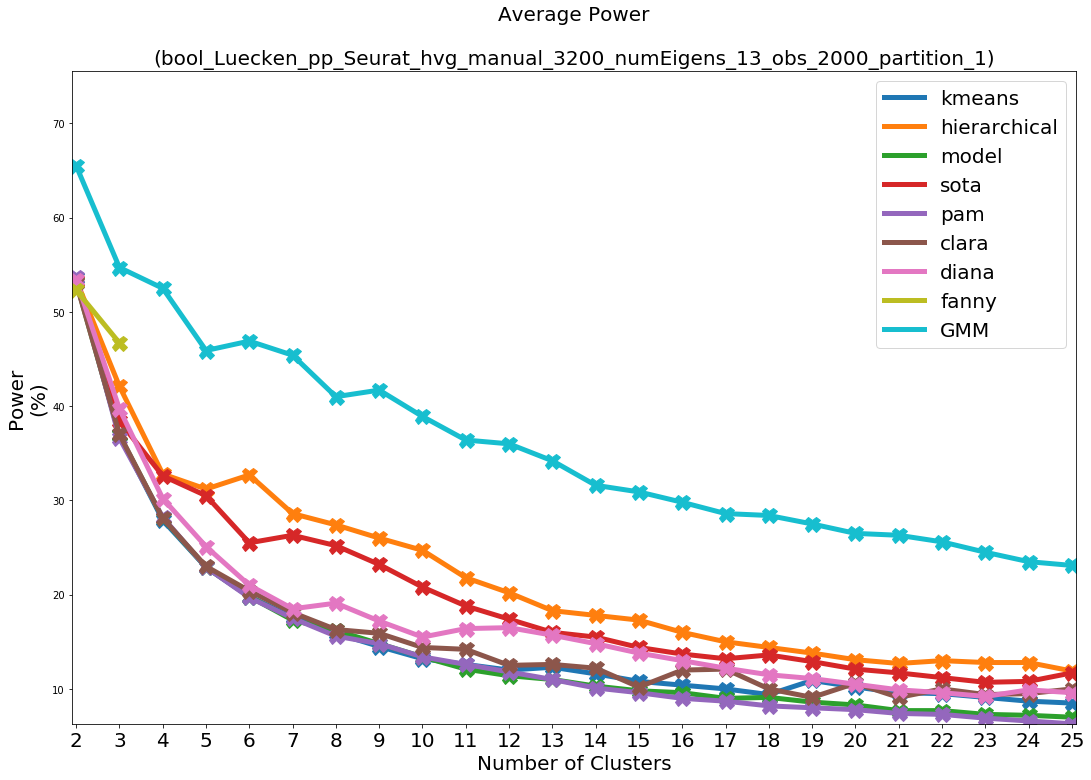

In [28]:
num_clusters = len(k_range)
plt.figure(figsize = (18,12))
colour_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:olive", "tab:cyan"]
max_power = max(df_power.iloc[:, 2])
min_power = min(df_power.iloc[:, 2])
cl_ = k_range[-1] - k_range[0]
plt.axis([-.1, cl_ + .1 , min_power, max_power + 10])

for i in range(num_cl_methods):
    first = i * num_clusters
    last = (i + 1) * num_clusters 
    plt.plot(range(num_clusters), df_power.iloc[first:last, 2], color=colour_list[i], 
             label=df_power.iloc[i*num_clusters, 0], linewidth = 5)
    plt.plot(range(num_clusters), df_power.iloc[first:last, 2], color=colour_list[i], 
             marker='X' , markersize=15, label='_nolegend_')

    
plt.legend(loc='upper right', fontsize = 20)
plt.title('Average Power\n\n({})'.format(hvg_bool_filename), fontsize = 20)

plt.xlabel('Number of Clusters', fontsize = 20)
plt.ylabel('Power\n(%)', fontsize = 20)
plt.xticks(range(num_clusters), num_clusters_list, fontsize = 20)
plot_file_name = data_loc + "avg_pwr_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

#### Calculate AIC and BIC

In [29]:
num_clusters = len(k_range)
df_ic = pd.DataFrame(0, index = np.arange(2*num_clusters), columns=["AIC", "BIC"])
df_ic.shape

(48, 2)

#### Calculate AIC, BIC for Gaussian mixture models

In [30]:
num_obs = reduced_hvg_mx.shape[0]
num_features = reduced_hvg_mx.shape[1]
row_counter =  0
 
for gmm_model in range(num_gmm_models):
    withinss = 0
    for obs_index in range(num_obs):
        label = gmm_labels[gmm_model][obs_index]-1
        cl_mean = gmm_models[gmm_model].means_[label].reshape(1, -1)
        k = gmm_models[gmm_model].n_components
        obs = reduced_hvg_mx[obs_index, :].reshape(1, -1)
        out = cdist(cl_mean, obs, 'sqeuclidean').sum()
        withinss += out
        
    AIC = round(2*withinss + k, 3)
    BIC = round(2*withinss + k*np.log(num_features), 3)
    df_ic.iloc[row_counter, 0] = AIC
    df_ic.iloc[row_counter, 1] = BIC
    print("AIC for GMM model with {} clusters: {}".format(k, AIC))
    print("BIC for GMM model with {} clusters: {}".format(k, BIC))
    print()
    row_counter += 1
    

AIC for GMM model with 2 clusters: 24.436
BIC for GMM model with 2 clusters: 27.566

AIC for GMM model with 3 clusters: 23.943
BIC for GMM model with 3 clusters: 28.637

AIC for GMM model with 4 clusters: 24.259
BIC for GMM model with 4 clusters: 30.519

AIC for GMM model with 5 clusters: 23.057
BIC for GMM model with 5 clusters: 30.881

AIC for GMM model with 6 clusters: 23.176
BIC for GMM model with 6 clusters: 32.566

AIC for GMM model with 7 clusters: 23.006
BIC for GMM model with 7 clusters: 33.96

AIC for GMM model with 8 clusters: 23.212
BIC for GMM model with 8 clusters: 35.732

AIC for GMM model with 9 clusters: 22.575
BIC for GMM model with 9 clusters: 36.66

AIC for GMM model with 10 clusters: 23.196
BIC for GMM model with 10 clusters: 38.845

AIC for GMM model with 11 clusters: 23.617
BIC for GMM model with 11 clusters: 40.831

AIC for GMM model with 12 clusters: 23.865
BIC for GMM model with 12 clusters: 42.645

AIC for GMM model with 13 clusters: 24.591
BIC for GMM model 

#### Calculate AIC, BIC for K-means model

In [31]:
print("\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
print("AIC and BIC for K-means using the Euclidean distance metric ")
      
num_models = len(ro.r("cl_obj_eucl@clusterObjs[[1]]"))

num_features = reduced_hvg_mx.shape[1]
num_obs = reduced_hvg_mx.shape[0]
for i in range (1, num_models +1):
    temp_string = 'cl_obj_eucl@clusterObjs[[1]][[' + str(i) + ']]'
    ss_string = temp_string + '$tot.withinss'
    ss = float(ro.r(ss_string))
    k_string = 'nrow(' + temp_string + '$centers)'
    k = float(ro.r(k_string))
    AIC = round(2*ss+k, 3)
    BIC = round(2*ss+k*np.log(num_features), 3)
    print("AIC for k-means model with {} clusters: {}".format(k, AIC))
    print("BIC for k-means model with {} clusters: {}".format(k, BIC))
    df_ic.iloc[row_counter, 0] = AIC
    df_ic.iloc[row_counter, 1] = BIC
    row_counter += 1
    print()



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
AIC and BIC for K-means using the Euclidean distance metric 
AIC for k-means model with 2.0 clusters: 6.67
BIC for k-means model with 2.0 clusters: 9.8

AIC for k-means model with 3.0 clusters: 6.867
BIC for k-means model with 3.0 clusters: 11.562

AIC for k-means model with 4.0 clusters: 7.497
BIC for k-means model with 4.0 clusters: 13.757

AIC for k-means model with 5.0 clusters: 8.245
BIC for k-means model with 5.0 clusters: 16.07

AIC for k-means model with 6.0 clusters: 9.019
BIC for k-means model with 6.0 clusters: 18.409

AIC for k-means model with 7.0 clusters: 9.835
BIC for k-means model with 7.0 clusters: 20.79

AIC for k-means model with 8.0 clusters: 10.78
BIC for k-means model with 8.0 clusters: 23.3

AIC for k-means model with 9.0 clusters: 11.632
BIC for k-means model with 9.0 clusters: 25.717

AIC for k-means model with 10.0 clusters: 12.502
BIC for k-means model with 10.0 clusters: 28.151

AIC for k-mea

#### Save AIC, BIC

In [32]:
df_ic.insert(0, "num_clusters", pd.Series(np.tile(num_clusters_list, 2)))
df_ic.insert(0, 'cl_method', pd.Series(np.repeat(["gmm", "kmeans"], num_clusters)))
df_ic

df_datafile = data_loc + 'AIC_BIC_' + hvg_bool_filename +  "_obs_" + str(reduced_hvg_mx.shape[0])
with open(df_datafile + '.pickle', 'wb') as handle:
    pickle.dump(df_ic, handle)

df_ic.to_csv(df_datafile + '.csv')

#### Plot AIC

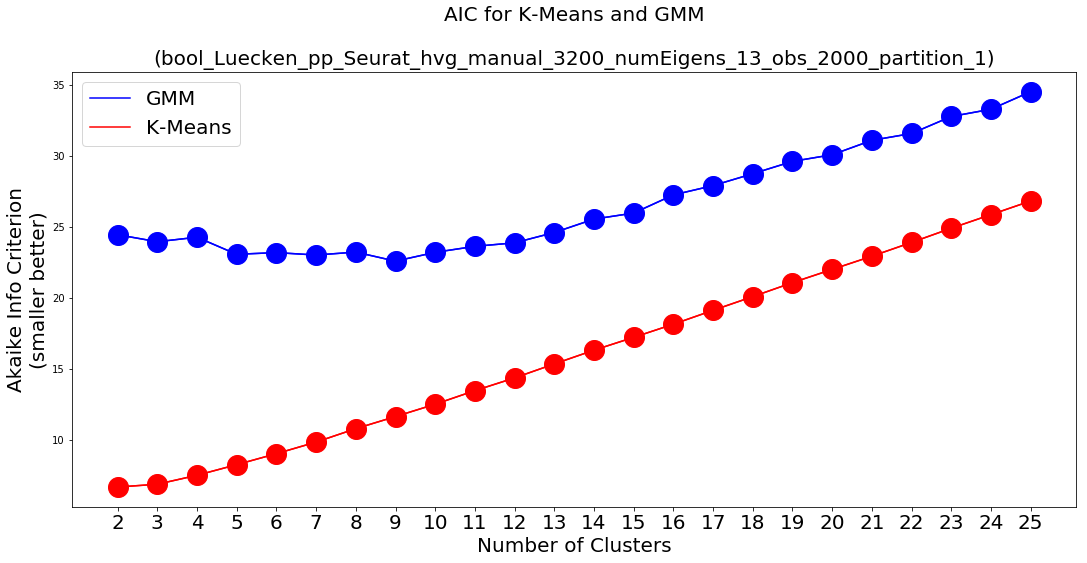

In [33]:
plt.figure(figsize = (18,8))
plt.plot(range(num_clusters), df_ic.iloc[:num_clusters, 2], color='blue', label = "GMM")
plt.plot(range(num_clusters), df_ic.iloc[:num_clusters, 2], color='blue', marker='o' , markersize=20, label='_nolegend_')
plt.plot(range(num_clusters), df_ic.iloc[num_clusters:, 2], color='red', label="K-Means")
plt.plot(range(num_clusters), df_ic.iloc[num_clusters:, 2], color='red', marker='o' , markersize=20, label='_nolegend_')
plt.legend(loc='upper left', fontsize = 20)

plt.title('AIC for K-Means and GMM\n\n({})'.format(hvg_bool_filename), fontsize = 20)
plt.xlabel('Number of Clusters', fontsize = 20)
plt.ylabel('Akaike Info Criterion\n(smaller better)', fontsize = 20)
plt.xticks(range(num_clusters), num_clusters_list, fontsize = 20)
plot_file_name = data_loc + "AIC_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

#### Plot BIC

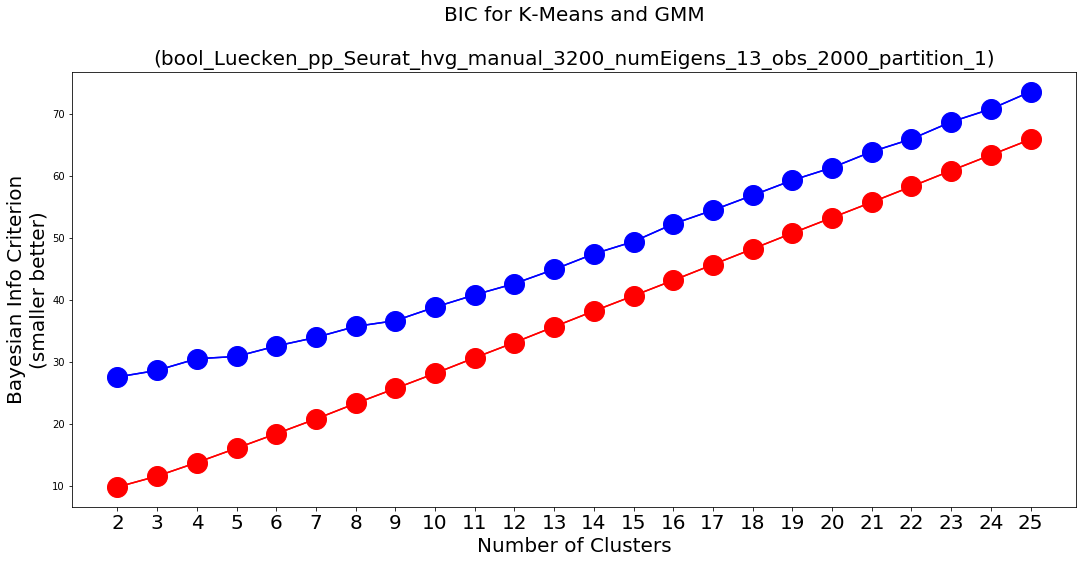

In [34]:
plt.figure(figsize = (18,8))
num_clusters = len(k_range)

plt.plot(range(num_clusters), df_ic.iloc[:num_clusters, 3], color='blue', label="GMM")
plt.plot(range(num_clusters), df_ic.iloc[:num_clusters, 3], color='blue', marker = 'o', markersize=20, label='_nolegend_')
plt.plot(range(num_clusters), df_ic.iloc[num_clusters:, 3], color='red', label="K-Means")
plt.plot(range(num_clusters), df_ic.iloc[num_clusters:, 3], color='red', marker = 'o', markersize=20, label='_nolegend_')


plt.title('BIC for K-Means and GMM\n\n({})'.format(hvg_bool_filename), fontsize = 20)
plt.xlabel('Number of Clusters', fontsize = 20)
plt.ylabel('Bayesian Info Criterion\n(smaller better)', fontsize = 20)
plt.xticks(range(num_clusters), num_clusters_list, fontsize = 20)
plot_file_name = data_loc + "BIC_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

#### Lists of cluster membership for extra three validity measures

In [35]:
cl_methods = ro.r('cl_obj_eucl@clMethods')
num_clusters_list = list(map(int, ro.r('cl_obj_eucl@nClust')))
cl_label_list_eucl = [] # Euclideand distance, cl_label_list list of triplets: [cluster method, k, values]
for i in range(1, 10): # "kmeans", "hierarchical", "model", "sota", "pam", "clara", "diana", "fanny", GMM
    label_name = 'clustering'
    if i  == 1: # kmeans
        label_name = 'cluster'
    elif i == 3: # model
        label_name = 'classification'
    elif i == 4: #sota
        label_name = 'clust'
    for j in range(int(ro.r('length(cl_obj_eucl@clusterObjs[[1]])') )):
        num_clusters  = num_clusters_list[j]
        
        # Euclidean
        if i == 2: #hierarchical
            label_string = 'cutree(cl_obj_eucl@clusterObjs[[2]], k = ' + str(num_clusters) + ')'
            labels = ro.r(label_string)
            partitions = []
            for cluster in range(1, num_clusters +1):
                partitions.append(np.where(labels == cluster)[0])
            cl_label_list_eucl.append([cl_methods[i-1], num_clusters, labels, partitions])
            
        elif i == 7: #diana
            label_string = 'cutree(cl_obj_eucl@clusterObjs[[7]], k = ' + str(num_clusters) + ')'
            labels = ro.r(label_string)
            partitions = []
            for cluster in range(1, num_clusters +1):
                partitions.append(np.where(labels == cluster)[0])
            cl_label_list_eucl.append([cl_methods[i-1], num_clusters, labels, partitions])
            
        elif i == 9: #GMM
            
            labels = gmm_labels[j]
            partitions = []
            for cluster in range(1, num_clusters + 1):
                partitions.append(np.where(np.array(labels) == cluster)[0])
            cl_label_list_eucl.append(["gmm", num_clusters, labels, partitions])
            
        else: # "kmeans", "model", "sota", "pam", "clara", "fanny"
            label_string = 'cl_obj_eucl@clusterObjs[[' + str(i) + "]][[" + str(j+1) + "]]$" + label_name
            labels = np.array(list(map(int, ro.r(label_string) )))
            partitions = []
            for cluster in range(1, num_clusters +1):
                partitions.append(np.where(labels == cluster)[0])
            cl_label_list_eucl.append([cl_methods[i-1], num_clusters, labels, partitions])
        
      

In [36]:
# make names of cluster method and number of clusters for Adjusted Rand,  Normalized Mutual Info and Variation of Info matrices

pd_col_row_names = []
num_k_per_method = int(len(cl_label_list_eucl)/9)
num_models = num_k_per_method * 9 #

for i in range(num_models):
    pd_col_row_names.append(cl_label_list_eucl[i][0] + str(cl_label_list_eucl[i][1]))

#### Declare an extra validity measure

In [37]:
def variation_of_information(X, Y):
  n = float(sum([len(x) for x in X]))
  sigma = 0.0
  for x in X:
    p = len(x) / n
    for y in Y:
      q = len(y) / n
      r = len(set(x) & set(y)) / n
      if r > 0.0:
        sigma += r * (log(r / p, 2) + log(r / q, 2))
  return abs(sigma)

### Adjusted rand, mutual info and variation of info matrices

In [38]:
# adj_rand_mx want large
# mutual_info_mx want large
# var_info_mx  want small
pd_col_row_names = pd_col_row_names[:184]
num_clusters = len(k_range)
adj_rand_mx_eucl = pd.DataFrame(0, index = pd_col_row_names + ["Total"], columns=pd_col_row_names)
mutual_info_mx_eucl = pd.DataFrame(0, index = pd_col_row_names + ["Total"], columns=pd_col_row_names)
var_info_mx_eucl = pd.DataFrame(0, index = pd_col_row_names + ["Total"], columns=pd_col_row_names)

for j in range(184):
    for i in range(184):
        if i != j:
            adj_rand_mx_eucl.iloc[i,j] = adjusted_rand_score(cl_label_list_eucl[i][2], cl_label_list_eucl[j][2])
            mutual_info_mx_eucl.iloc[i,j] = normalized_mutual_info_score(cl_label_list_eucl[i][2], cl_label_list_eucl[j][2])
            var_info_mx_eucl.iloc[i,j] = variation_of_information(cl_label_list_eucl[i][3], cl_label_list_eucl[j][3])
    adj_rand_mx_eucl.iloc[i+1,j] = adj_rand_mx_eucl.iloc[:i+1,j].sum()
    mutual_info_mx_eucl.iloc[i+1,j] = mutual_info_mx_eucl.iloc[:i+1,j].sum()
    var_info_mx_eucl.iloc[i+1,j] = var_info_mx_eucl.iloc[:i+1,j].sum()

# save dataframe and csv of adjusted rand mx
adj_rand_mx_eucl_file_name = data_loc + 'adj_rand_mx_AE_eucl_' + hvg_bool_filename + '.pickle'
adj_rand_mx_eucl.to_pickle(adj_rand_mx_eucl_file_name)
adj_rand_mx_eucl.to_csv(adj_rand_mx_eucl_file_name + '.csv')
print("\n\nAdjusted Rand Index matrix for Euclidean distance:")
display(adj_rand_mx_eucl)

# save dataframe and csv of mutual info mx
mutual_info_mx_file_name = data_loc + 'mutual_info_mx_AE_eucl_' + hvg_bool_filename + '.pickle'
mutual_info_mx_eucl.to_pickle(mutual_info_mx_file_name)
mutual_info_mx_eucl.to_csv(mutual_info_mx_file_name + '.csv')
print("\n\nMutual Information matrix for Euclidean distance:")
display(mutual_info_mx_eucl)

# save dataframe and csv of variation of info mx
var_info_mx_eucl_file_name = data_loc + 'var_info_mx_AE_eucl_' + hvg_bool_filename + '.pickle'
var_info_mx_eucl.to_pickle(var_info_mx_eucl_file_name)
var_info_mx_eucl.to_csv(var_info_mx_eucl_file_name + '.csv')
print("\n\nVariation of Information matrix for Euclidean distance:")
display(adj_rand_mx_eucl)




Adjusted Rand Index matrix for Euclidean distance:


,kmeans2,kmeans3,kmeans4,kmeans5,kmeans6,kmeans7,kmeans8,kmeans9,kmeans10,kmeans11,...,fanny8,fanny9,fanny10,fanny11,fanny12,fanny13,fanny14,fanny15,fanny16,fanny17
kmeans2,0.000000,0.350493,0.168606,0.142427,0.101934,0.102805,0.102591,0.083700,0.071105,0.071273,...,0.186317,0.115292,0.269401,0.0,0.0,0.0,0.045668,0.236474,0.0,0.0
kmeans3,0.350493,0.000000,0.502670,0.437001,0.337806,0.317863,0.312061,0.269941,0.227801,0.225841,...,0.038766,0.719322,0.252152,0.0,0.0,0.0,0.008784,0.098206,0.0,0.0
kmeans4,0.168606,0.502670,0.000000,0.756691,0.499909,0.556627,0.548240,0.412079,0.359735,0.353111,...,0.015781,0.357288,0.105776,0.0,0.0,0.0,0.003463,0.035933,0.0,0.0
kmeans5,0.142427,0.437001,0.756691,0.000000,0.643465,0.668368,0.659622,0.514558,0.450606,0.446312,...,0.012209,0.312562,0.084428,0.0,0.0,0.0,0.002646,0.026083,0.0,0.0
kmeans6,0.101934,0.337806,0.499909,0.643465,0.000000,0.533190,0.522380,0.636213,0.560584,0.555854,...,0.007066,0.256043,0.044735,0.0,0.0,0.0,0.001474,0.011102,0.0,0.0
kmeans7,0.102805,0.317863,0.556627,0.668368,0.533190,0.000000,0.989217,0.575205,0.522729,0.516212,...,0.008622,0.235444,0.048335,0.0,0.0,0.0,0.001994,0.013393,0.0,0.0
kmeans8,0.102591,0.312061,0.548240,0.659622,0.522380,0.989217,0.000000,0.584013,0.531425,0.522206,...,0.009890,0.230283,0.050830,0.0,0.0,0.0,0.002146,0.014885,0.0,0.0
kmeans9,0.083700,0.269941,0.412079,0.514558,0.636213,0.575205,0.584013,0.000000,0.747492,0.735022,...,0.007476,0.213719,0.035560,0.0,0.0,0.0,0.001603,0.009939,0.0,0.0
kmeans10,0.071105,0.227801,0.359735,0.450606,0.560584,0.522729,0.531425,0.747492,0.000000,0.987246,...,0.005924,0.184538,0.033189,0.0,0.0,0.0,0.001244,0.007316,0.0,0.0
kmeans11,0.071273,0.225841,0.353111,0.446312,0.555854,0.516212,0.522206,0.735022,0.987246,0.000000,...,0.006137,0.181666,0.034200,0.0,0.0,0.0,0.001382,0.008443,0.0,0.0




Mutual Information matrix for Euclidean distance:


,kmeans2,kmeans3,kmeans4,kmeans5,kmeans6,kmeans7,kmeans8,kmeans9,kmeans10,kmeans11,...,fanny8,fanny9,fanny10,fanny11,fanny12,fanny13,fanny14,fanny15,fanny16,fanny17
kmeans2,0.000000,0.613504,0.456368,0.431082,0.395921,0.412052,0.414352,0.400149,0.384482,0.389185,...,0.190900,0.203257,0.136005,3.562500,3.562500,3.562500,0.083212,0.106776,3.562500,3.562500
kmeans3,0.613504,0.000000,0.646033,0.592439,0.543096,0.525730,0.516147,0.498247,0.465439,0.466396,...,0.120243,0.660815,0.209913,0.500000,0.500000,0.500000,0.052405,0.131207,0.500000,0.500000
kmeans4,0.456368,0.646033,0.000000,0.802529,0.629448,0.650394,0.640092,0.547558,0.534165,0.525621,...,0.103336,0.452803,0.184367,0.375000,0.375000,0.375000,0.044990,0.119376,0.375000,0.375000
kmeans5,0.431082,0.592439,0.802529,0.000000,0.756722,0.749652,0.738290,0.634995,0.612054,0.606009,...,0.097366,0.413287,0.172450,0.375000,0.375000,0.375000,0.042391,0.114149,0.375000,0.375000
kmeans6,0.395921,0.543096,0.629448,0.756722,0.000000,0.668444,0.658288,0.707883,0.662674,0.656262,...,0.090918,0.399542,0.166616,3.625000,3.625000,3.625000,0.039577,0.108442,3.625000,3.625000
kmeans7,0.412052,0.525730,0.650394,0.749652,0.668444,0.000000,0.980007,0.701860,0.690650,0.682331,...,0.102893,0.362459,0.157829,3.750000,3.750000,3.750000,0.036821,0.105845,3.750000,3.750000
kmeans8,0.414352,0.516147,0.640092,0.738290,0.658288,0.980007,0.000000,0.723887,0.711834,0.696670,...,0.102225,0.358179,0.160413,3.875000,3.875000,3.875000,0.039487,0.106950,3.875000,3.875000
kmeans9,0.400149,0.498247,0.547558,0.634995,0.707883,0.701860,0.723887,0.000000,0.818891,0.798399,...,0.097930,0.372127,0.151356,2.000000,2.000000,2.000000,0.037992,0.092101,2.000000,2.000000
kmeans10,0.384482,0.465439,0.534165,0.612054,0.662674,0.690650,0.711834,0.818891,0.000000,0.977918,...,0.094790,0.349639,0.152574,1.250000,1.250000,1.250000,0.036615,0.107165,1.250000,1.250000
kmeans11,0.389185,0.466396,0.525621,0.606009,0.656262,0.682331,0.696670,0.798399,0.977918,0.000000,...,0.097438,0.349220,0.149564,0.750000,0.750000,0.750000,0.041068,0.106263,0.750000,0.750000




Variation of Information matrix for Euclidean distance:


,kmeans2,kmeans3,kmeans4,kmeans5,kmeans6,kmeans7,kmeans8,kmeans9,kmeans10,kmeans11,...,fanny8,fanny9,fanny10,fanny11,fanny12,fanny13,fanny14,fanny15,fanny16,fanny17
kmeans2,0.000000,0.350493,0.168606,0.142427,0.101934,0.102805,0.102591,0.083700,0.071105,0.071273,...,0.186317,0.115292,0.269401,0.0,0.0,0.0,0.045668,0.236474,0.0,0.0
kmeans3,0.350493,0.000000,0.502670,0.437001,0.337806,0.317863,0.312061,0.269941,0.227801,0.225841,...,0.038766,0.719322,0.252152,0.0,0.0,0.0,0.008784,0.098206,0.0,0.0
kmeans4,0.168606,0.502670,0.000000,0.756691,0.499909,0.556627,0.548240,0.412079,0.359735,0.353111,...,0.015781,0.357288,0.105776,0.0,0.0,0.0,0.003463,0.035933,0.0,0.0
kmeans5,0.142427,0.437001,0.756691,0.000000,0.643465,0.668368,0.659622,0.514558,0.450606,0.446312,...,0.012209,0.312562,0.084428,0.0,0.0,0.0,0.002646,0.026083,0.0,0.0
kmeans6,0.101934,0.337806,0.499909,0.643465,0.000000,0.533190,0.522380,0.636213,0.560584,0.555854,...,0.007066,0.256043,0.044735,0.0,0.0,0.0,0.001474,0.011102,0.0,0.0
kmeans7,0.102805,0.317863,0.556627,0.668368,0.533190,0.000000,0.989217,0.575205,0.522729,0.516212,...,0.008622,0.235444,0.048335,0.0,0.0,0.0,0.001994,0.013393,0.0,0.0
kmeans8,0.102591,0.312061,0.548240,0.659622,0.522380,0.989217,0.000000,0.584013,0.531425,0.522206,...,0.009890,0.230283,0.050830,0.0,0.0,0.0,0.002146,0.014885,0.0,0.0
kmeans9,0.083700,0.269941,0.412079,0.514558,0.636213,0.575205,0.584013,0.000000,0.747492,0.735022,...,0.007476,0.213719,0.035560,0.0,0.0,0.0,0.001603,0.009939,0.0,0.0
kmeans10,0.071105,0.227801,0.359735,0.450606,0.560584,0.522729,0.531425,0.747492,0.000000,0.987246,...,0.005924,0.184538,0.033189,0.0,0.0,0.0,0.001244,0.007316,0.0,0.0
kmeans11,0.071273,0.225841,0.353111,0.446312,0.555854,0.516212,0.522206,0.735022,0.987246,0.000000,...,0.006137,0.181666,0.034200,0.0,0.0,0.0,0.001382,0.008443,0.0,0.0


### Adjusted rand, mutual info and variation of info plots

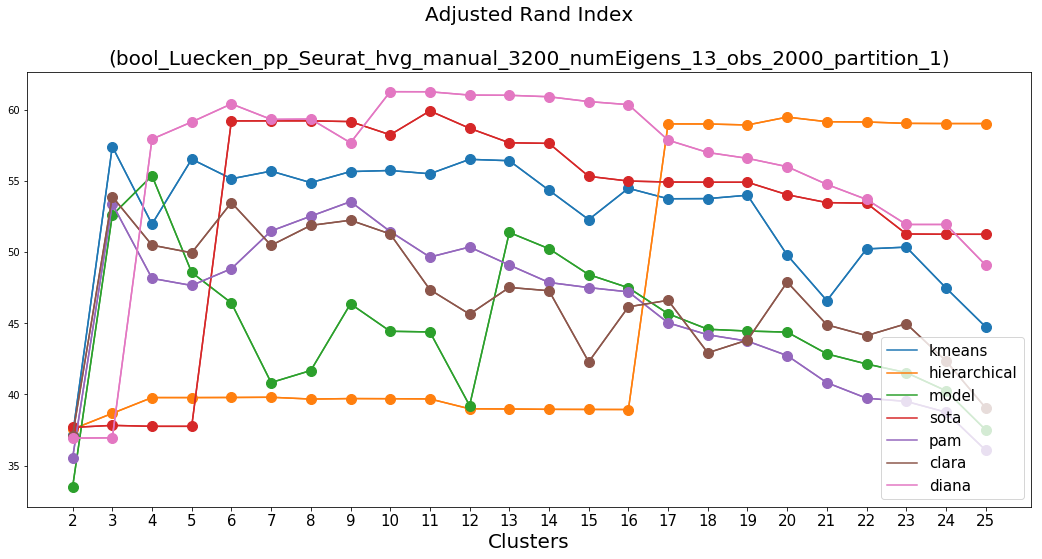

In [39]:

# Adjusted Rand Index plot
colour_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", 
               "tab:olive", "tab:cyan"]
method_list = ["kmeans", "hierarchical", "model", "sota", "pam", "clara", "diana", "fanny", "gmm"]
points = len(range(k_min, k_max + 1))

plt.figure(figsize = (18,8))
for i in range(7):
    plt.plot(range(k_min, k_max + 1), adj_rand_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             label=method_list[i])
    plt.plot(range(k_min, k_max + 1), adj_rand_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             marker='o' , markersize=10, label='_nolegend_')

plt.xlabel('Clusters', fontsize = 20)

#     plt.yticks("")
plt.xticks(range(k_min, k_max + 1),  range(k_min, k_max + 1), fontsize = 15)
plt.legend(loc='lower right', fontsize = 15)
plt.title('Adjusted Rand Index\n\n({})'.format(hvg_bool_filename), fontsize = 20)

plot_file_name = data_loc + "adj_rand_mx_eucl_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

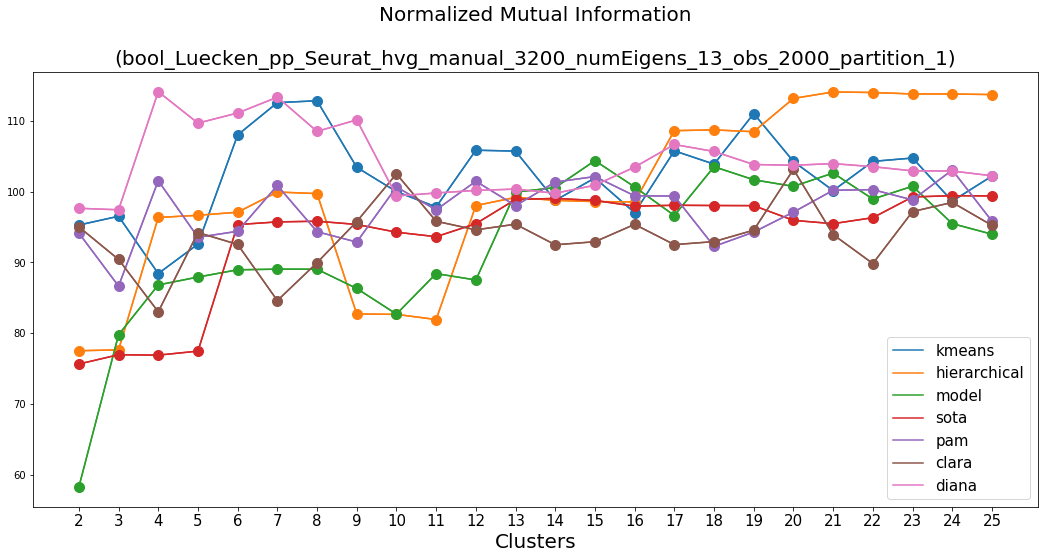

In [40]:
# Normalized Mutual Information plot
colour_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", 
               "tab:olive", "tab:cyan"]
method_list = ["kmeans", "hierarchical", "model", "sota", "pam", "clara", "diana", "fanny", "gmm"]
points = len(range(k_min, k_max + 1))

plt.figure(figsize = (18,8))
for i in range(7):
    plt.plot(range(k_min, k_max + 1), mutual_info_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             label=method_list[i])
    plt.plot(range(k_min, k_max + 1), mutual_info_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             marker='o' , markersize=10, label='_nolegend_')

plt.xlabel('Clusters', fontsize = 20)

#     plt.yticks("")
plt.xticks(range(k_min, k_max + 1),  range(k_min, k_max + 1), fontsize = 15)
plt.legend(loc='lower right', fontsize = 15)
plt.title('Normalized Mutual Information\n\n({})'.format(hvg_bool_filename), fontsize = 20)

plot_file_name = data_loc + "mutual_info_mx_eucl_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

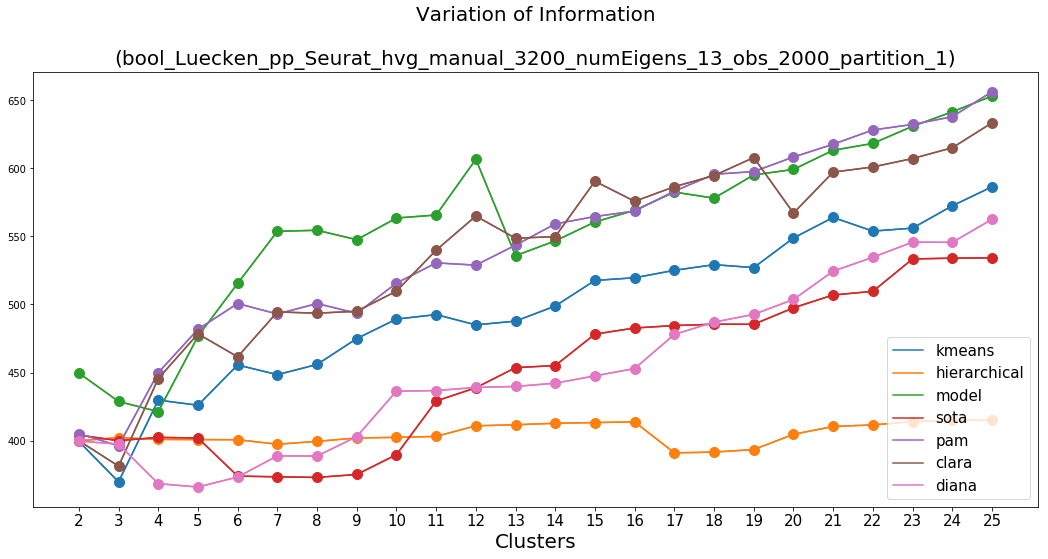

In [41]:

# Variation of Information plot
colour_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", 
               "tab:olive", "tab:cyan"]
method_list = ["kmeans", "hierarchical", "model", "sota", "pam", "clara", "diana", "fanny", "gmm"]
points = len(range(k_min, k_max + 1))

plt.figure(figsize = (18,8))
for i in range(7):
    plt.plot(range(k_min, k_max + 1), var_info_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             label=method_list[i])
    plt.plot(range(k_min, k_max + 1), var_info_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             marker='o' , markersize=10, label='_nolegend_')

plt.xlabel('Clusters', fontsize = 20)

#     plt.yticks("")
plt.xticks(range(k_min, k_max + 1),  range(k_min, k_max + 1), fontsize = 15)
plt.legend(loc='lower right', fontsize = 15)
plt.title('Variation of Information\n\n({})'.format(hvg_bool_filename), fontsize = 20)

plot_file_name = data_loc + "var_info_mx_eucl_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')